<a href="https://colab.research.google.com/github/mehedils/ColabCodeRandom/blob/main/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Downloading the dataset

In [3]:
#!/bin/bash
!curl -L -o plantvillage-tomato-leaf-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/charuchaudhry/plantvillage-tomato-leaf-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  443M  100  443M    0     0  86.9M      0  0:00:05  0:00:05 --:--:--  100M


In [4]:
!unzip -qq plantvillage-tomato-leaf-dataset.zip
!ls

replace plantvillage/Tomato___Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
plantvillage  plantvillage-tomato-leaf-dataset.zip  sample_data


In [5]:
!rm -rf ./plantvillage/plantvillage/

# Preprocessing data

In [6]:
BASE_DIR = "plantvillage"
BATCH_SIZE = 64
IMG_SIZE = 64
CHANNELS = 3

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    BASE_DIR,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 14529 files belonging to 10 classes.


In [9]:
class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

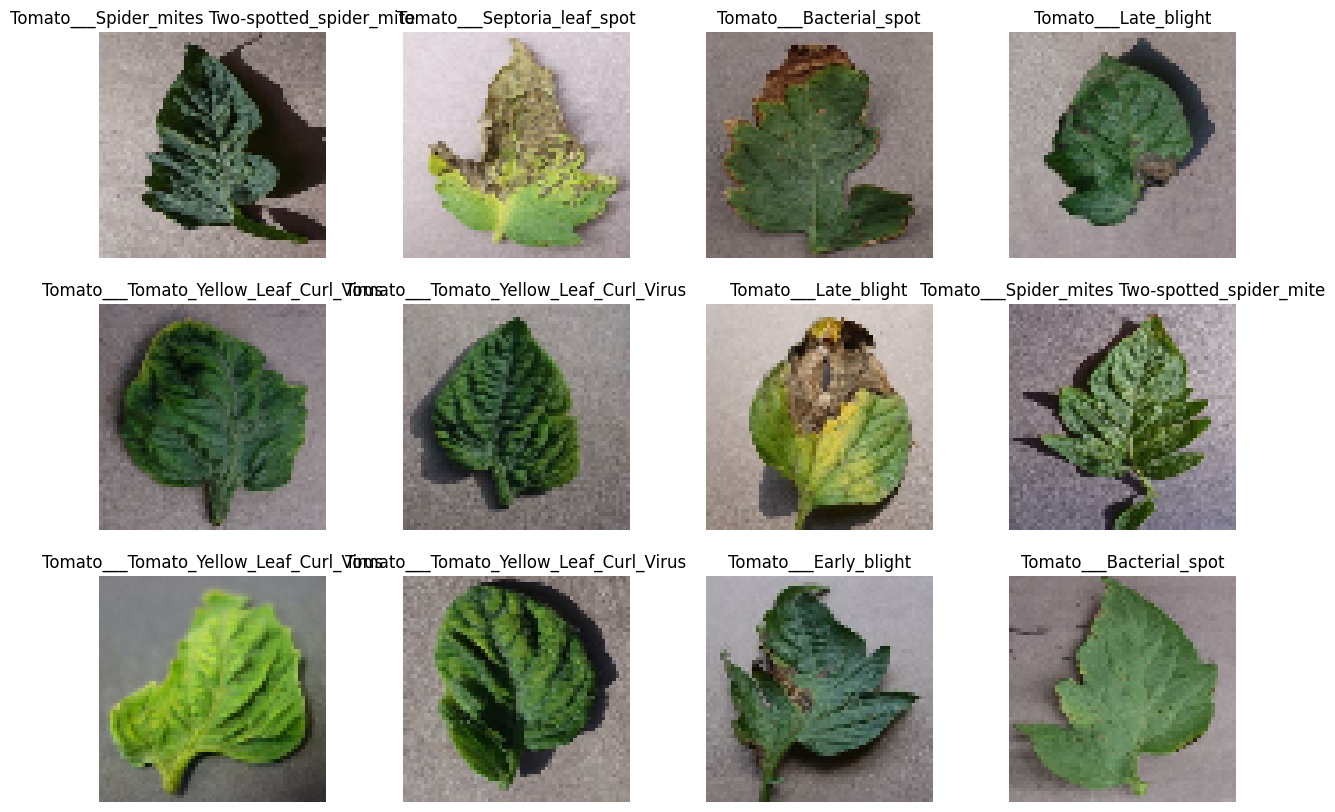

In [10]:
plt.figure(figsize=(15, 10))

for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [12]:
def split_dataset(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  dataset_size = len(dataset)
  if shuffle:
    dataset = dataset.shuffle(shuffle_size)
  train_size = int(train_split * dataset_size)
  val_size = int(val_split * dataset_size)

  train_dataset = dataset.take(train_size)
  val_dataset = dataset.skip(train_size).take(val_size)
  test_dataset = dataset.skip(train_size).skip(val_size)

  return train_dataset, val_dataset, test_dataset

In [13]:
train_ds, val_ds, test_ds = split_dataset(dataset)

In [14]:
train_ds = train_ds.shuffle(1000).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)
])



In [16]:
base_model = tf.keras.applications.ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS),
)

base_model.trainable = False


# Create the custom model

In [17]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),  # or tf.keras.layers.Flatten()
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Optional: helps prevent overfitting
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Optional: helps prevent overfitting
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  # Final output layer for 10 classes
])

In [18]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # or 'sparse_categorical_crossentropy'
    metrics=['accuracy']
)

In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)          │ (None, 2, 2, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,872,778 (167.36 MB)

 Trainable params: 1,214,602 (4.63 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

In [22]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    verbose=1
)

Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8864 - loss: 0.3320 - val_accuracy: 0.9226 - val_loss: 0.2282
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8887 - loss: 0.3339 - val_accuracy: 0.9261 - val_loss: 0.2225
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.8957 - loss: 0.3081 - val_accuracy: 0.9261 - val_loss: 0.2209
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8981 - loss: 0.2964 - val_accuracy: 0.9389 - val_loss: 0.1944
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9125 - loss: 0.2780 - val_accuracy: 0.9403 - val_loss: 0.1953
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9078 - loss: 0.2738 - val_accuracy: 0.9432 - val_loss: 0.1893
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9115 - loss: 0.2493 - val_accuracy: 0.9425 - val_loss: 0.1833
Epoch 8/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9146 - loss: 0.2498 - val_accu

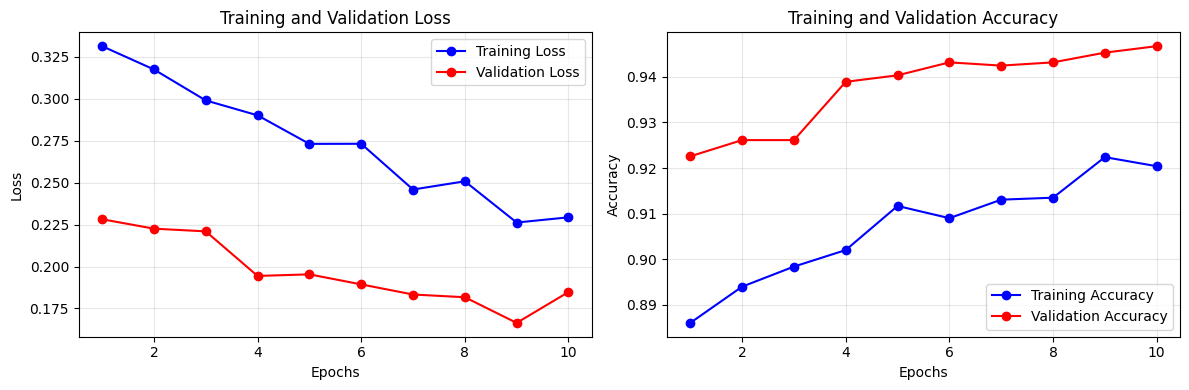

In [23]:
import matplotlib.pyplot as plt

# Get metrics from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Create the plots
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
# Evaluate on test dataset
test_results = model.evaluate(test_ds, verbose=1)

# If you compiled your model with metrics like ['accuracy', 'precision', 'recall']
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")

# If you have more metrics, access them by index
# test_results[2] would be precision, [3] recall, etc.

24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9423 - loss: 0.1683
Test Loss: 0.1655
Test Accuracy: 0.9453
